In [4]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath

In [5]:
rospy.init_node('notebook')

In [6]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnosti

In [7]:
import time

bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)

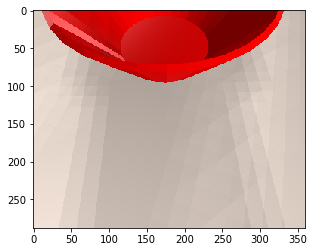

In [8]:
plt.imshow(left_image)

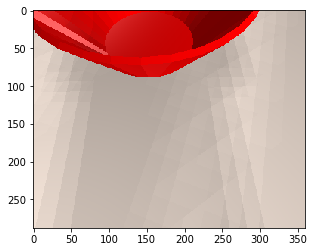

In [9]:
plt.imshow(right_image)

In [10]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 3619
  stamp: 
    secs: 1617695351
    nsecs:  77624083
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 3619
  stamp: 
    secs: 1617695351
    nsecs:  77624083
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  

In [11]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')

HARDCODED_ECM_POS = np.array([0.0, 0.0, 0.04, 0.0])

In [12]:
tf_listener = tf.TransformListener()

In [13]:
tf_listener.getFrameStrings()

/home/iandre/dvrk_ws/src/geometry/tf/src/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_base',
 'PSM3_base',
 'PSM1_RCM',
 'PSM1',
 'PSM2',
 'PSM3',
 'ecm_insertion_link',
 'Vision_sensor_left',
 'simworld',
 'ECM_RCM',
 'ECM_base',
 'ECM',
 'Jp21_ECM',
 'camera',
 'PSM1_base',
 'PSM3_RCM',
 'PSM2_RCM',
 'J1_PSM1',
 'ecm_pitch_link_1',
 'J1_PSM2']

In [14]:
import time
time.sleep(1)
ecm.move_joint(HARDCODED_ECM_POS)

True

[    -1.46149,  0.00644616,    0.655595]


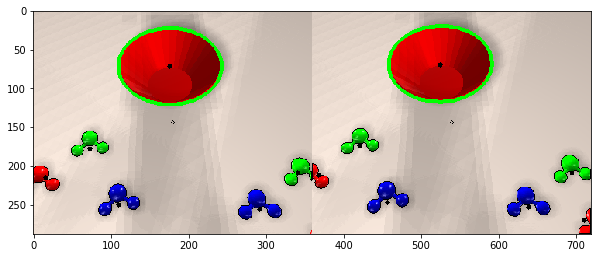

In [15]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF
import image_geometry

stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))
tf_world_to_psm1 = \
    tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))

objects, left_frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)

ball_pos_cam = objects[0].pos
print(ball_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(left_frame)
# depth error experiments
# (-0.02772727272727273, 0.009545454545454546, 0.14180015986663413) {-0.02987164259, 0.01018744707, 0.1481492519}
# (-0.028636363636363637, 0.01, 0.14180015986663413) {-0.02869459987, 0.009940028191, 0.1379978657} 
# (-0.013333333333333334, 0.010416666666666666, 0.12998347987774794) {-0.01380112767, 0.009659290314, 0.1300171614} 
# (0.04038461538461539, 0.008076923076923077, 0.11998475065638273) {-0.009348809719, 0.01096570492, 0.1307697296} 

In [16]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)
tf_cam_to_jp21 = tf_to_pykdl_frame(tf_listener.lookupTransform('ecm_pitch_link_1', 'camera', rospy.Time()))
ball_pos_jp21 = tf_cam_to_jp21 * ball_pos_cam
ball_pos_jp21

[    -1.46149,  0.00644616,    0.655595]

In [17]:
# did this to confirm that the /tf transforms provided by dVRK are within margin of error of 
# actual sim coordinates
tf_insertion_to_jp21 = tf_listener.lookupTransform('ecm_pitch_link_1', 'ecm_insertion_link', rospy.Time())
tf_insertion_to_jp21

([0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0])

In [18]:
tf_jp21_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('world', 'Jp21_ECM', rospy.Time()))
ball_pos_world = tf_jp21_to_world * ball_pos_jp21
# i'm a winner
ball_pos_world

[    -2.55274,    -0.61582,     0.27293]

In [19]:
tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'world', rospy.Time()))
ball_pos_psm2_j1 = tf_world_to_psm2_j1 * ball_pos_world
# ok not off by *too* much
ball_pos_psm2_j1

[    0.362233,     0.52628,    -1.20936]

In [20]:
ball_pos_psm2_main = PSM_J1_TO_BASE_LINK_TF * ball_pos_psm2_j1
ball_pos_psm2_main

[   -0.362233,     1.20936,    -0.52628]

#### 

In [21]:
psm2_rot = psm2.get_current_position().M
psm2_pos = psm2.get_current_position().p
psm2_pos

[    -1.95009,  -0.0927861,   -0.792173]

In [22]:
psm2.move(ball_pos_psm2_main)

True

In [23]:
cam_z_vec_world = (tf_jp21_to_world * tf_cam_to_jp21).M * PyKDL.Vector(0, 0, 1.0)
cam_z_vec_psm2_main = (PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1).M * cam_z_vec_world

In [ ]:
psm2.move_joint_one(0., 5)
psm2.open_jaw()
psm2.dmove(0.03 * cam_z_vec_psm2_main)
psm2.close_jaw()

In [28]:
psm2.dmove( PyKDL.Vector(0, 0, 0.1))

True

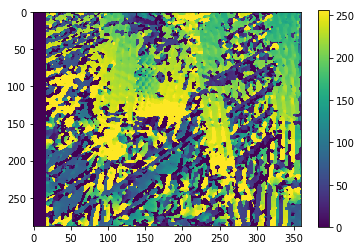

In [29]:
stereo = cv2.StereoSGBM_create(minDisparity=1, numDisparities=16, blockSize=5)

left_image_bw = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_bw = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)
disparity_map = stereo.compute(left_image_bw, right_image_bw)
plt.imshow(disparity_map)
plt.colorbar()

[[[190 226]]

 [[189 227]]

 [[188 227]]

 [[187 228]]

 [[186 228]]

 [[185 229]]

 [[185 230]]

 [[183 232]]

 [[183 234]]

 [[182 235]]

 [[182 240]]

 [[183 241]]

 [[183 243]]

 [[184 244]]

 [[184 245]]

 [[187 248]]

 [[188 248]]

 [[189 249]]

 [[190 249]]

 [[191 250]]

 [[196 250]]

 [[197 249]]

 [[199 249]]

 [[200 248]]

 [[202 248]]

 [[205 251]]

 [[205 252]]

 [[204 253]]

 [[204 255]]

 [[203 256]]

 [[203 264]]

 [[204 265]]

 [[204 267]]

 [[205 268]]

 [[205 269]]

 [[206 270]]

 [[206 271]]

 [[208 273]]

 [[208 274]]

 [[209 274]]

 [[212 277]]

 [[213 277]]

 [[214 278]]

 [[216 278]]

 [[217 279]]

 [[224 279]]

 [[225 278]]

 [[227 278]]

 [[228 277]]

 [[229 277]]

 [[234 272]]

 [[234 271]]

 [[235 270]]

 [[235 269]]

 [[236 268]]

 [[236 265]]

 [[237 264]]

 [[237 260]]

 [[236 259]]

 [[236 256]]

 [[235 255]]

 [[235 254]]

 [[234 253]]

 [[234 252]]

 [[237 249]]

 [[239 251]]

 [[240 251]]

 [[241 252]]

 [[248 252]]

 [[249 251]]

 [[250 251]]

 [[251

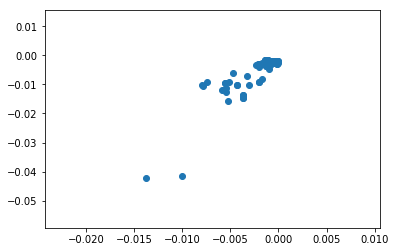

In [30]:
from feature_processor import feature_processor
from pick_and_place_utils import FEAT_PATHS, CV_TO_CAM_FRAME_ROT
fp = feature_processor(FEAT_PATHS)
feats, frame = fp.FindImageFeatures(left_image_msg)
bowl = max(feats, key=lambda feat : cv2.contourArea(feat.contour))
bowl_pts_cam = []
print(bowl.contour)

for pt_ in bowl.contour:
    pt = tuple(np.clip(pt_[0], (0, 0), np.array(left_image_bw.shape) - np.array([1, 1])))
    disparity = disparity_map[pt]
    if disparity < 1:
        continue
    print(disparity)
    cam_xyz = stereo_cam.projectPixelTo3d(pt, disparity)
    cam_pt = np.matmul(CV_TO_CAM_FRAME_ROT, cam_xyz)
    bowl_pts_cam.append(PyKDL.Vector(*cam_pt))

plt.scatter([pt[0] for pt in bowl_pts_cam], [pt[1] for pt in bowl_pts_cam])

In [31]:
import plotly
import plotly.graph_objects as go 

plotly.offline.init_notebook_mode()
trace = go.Scatter3d(
    x = [pt[0] for pt in bowl_pts_cam],
    y = [pt[1] for pt in bowl_pts_cam],
    z = [pt[2] for pt in bowl_pts_cam],
    mode = 'markers', 
    marker = {
            'size': 5,
            'opacity': 0.8,
        })

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}

)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)
plotly.offline.iplot(plot_figure)
# StereoSGBM officially a failed experiment
# the point cloud plot is pretty cool though

In [33]:
from feature_processor import FeatureType
bowl_obj = None
for obj in objects:
    if obj.type == FeatureType.BOWL:
        bowl_obj = obj
bowl_obj.pos

[    -1.54133, -0.00296429,    0.672683]

In [34]:
bowl_pos_cam = PyKDL.Vector(*bowl_obj.pos)
bowl_pos_world = tf_jp21_to_world * (tf_cam_to_jp21 * bowl_pos_cam)
bowl_pos_psm2_main = PSM_J1_TO_BASE_LINK_TF * (tf_world_to_psm2_j1 * bowl_pos_world)
# add a little bit to the z-axis to avoid hitting the bowl
dest_psm2 = bowl_pos_psm2_main + PyKDL.Vector(0, 0, 0.1)
psm2.move(dest_psm2)
psm2.open_jaw()

AttributeError: Object3d instance has no attribute 'pos_cam'